# Visualzing Word Embeddings

This notebook is to visualize our trained embeddings.

In [22]:
import os
import re
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from gensim import models
from gensim.models import Word2Vec, KeyedVectors, LsiModel, LdaModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

# from wordcloud import WORDCLOUD

import pyLDAvis
import pyLDAvis.gensim

from utils import embedding_info, load_word_vectors, standardize_string #, most_similar_words
from load import Loader

In [2]:
# Helper functions
def extract_word_vectors(model: Word2Vec):
    print("Word count: ", len(model.wv.index_to_key))
    print("Vector dimension: ", model.wv.vector_size)
    return np.array([model.wv[word] for word in model.wv.index_to_key])

def pca_reduction(vectors, n_components=2):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(vectors)

def tsne_reduction(vectors, n_components=2, perplexity=30.0):
    tsne = TSNE(n_components=n_components, perplexity=perplexity)
    return tsne.fit_transform(vectors)

def plot_pca(fig, vectors, labels, three_dim=False):
    if three_dim:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2], c='r', marker='o')
        for i, label in enumerate(labels):
            ax.text(vectors[i, 0], vectors[i, 1], vectors[i, 2], label)
    else:
        plt.scatter(vectors[:, 0], vectors[:, 1], c='r', marker='o')
        for i, label in enumerate(labels):
            plt.text(vectors[i, 0], vectors[i, 1], label)
            
def similar_nonsimilar(words, embeddings: KeyedVectors, reduction='pca', reduction_components=2, k=5):
    word_groups = []
    for word in words:
        similar_words = [(word, 1.0)] + embeddings.most_similar(word, topn=k)
        word_groups.append(similar_words)
        
    all_words =  [word for group in word_groups for word, _ in group]
    
    # Get the vectors for all similar words
    total_word_vec = np.empty((0, embeddings.vector_size))  # Create an empty total_word_vec
    for group in word_groups:
        similar_word_vecs = np.array([embeddings[word] for word, _ in group])
        total_word_vec = np.concatenate((total_word_vec, similar_word_vecs), axis=0)
        
    if reduction == 'pca':
        reduction_total_word_vecs = pca_reduction(total_word_vec, n_components=reduction_components)
    elif reduction == 'tsne':
        reduction_total_word_vecs = tsne_reduction(total_word_vec, n_components=reduction_components, perplexity=2)
    return all_words, reduction_total_word_vecs


def most_similar_words(embeddings, word, k):
    """
    Get the top k most similar words to a word
    embeddings is of form {word1: vector1, word2: vector2, ...}
    """
    
    word = standardize_string(word)
    word_vector = embeddings[word]
    
    similarity = {}
    for w, v in embeddings.items():
        try:
            similarity[w] = np.dot(word_vector, v) / (np.linalg.norm(word_vector) * np.linalg.norm(v))
        except Exception as e:
            continue

        
    # Return list of [(word, similarity), ...]
    return sorted(similarity.items(), key=lambda x: x[1], reverse=True)[:k]
    

## Daily Dialogue
Here, we perform some visualization on the word embeddings of daily dialogue.Let's visualize the embeddings first.

In [20]:
# %pip install pyLDAvis
import pyLDAvis
from load import Loader
dailydialog_kv = Word2Vec.load('./out/dailydialog_word2vec_100.model')
dailydialog_lsi_kv = LsiModel.load("./out/dailydialog_LsiModel_100.model")
print(dailydialog_lsi_kv)
topics = dailydialog_lsi_kv.print_topics(dailydialog_lsi_kv.num_topics)
for topic in topics:
    print(topic)


LsiModel<num_terms=18683, num_topics=3, decay=1.0, chunksize=20000>
(0, '0.499*"i" + 0.381*"the" + 0.358*"you" + 0.327*"to" + 0.247*"a" + 0.193*"it" + 0.173*"and" + 0.130*"of" + 0.126*"s" + 0.125*"that"')
(1, '-0.759*"i" + 0.442*"you" + 0.381*"the" + -0.106*"m" + 0.089*"are" + 0.085*"is" + 0.076*"of" + -0.074*"my" + 0.072*"we" + 0.069*"s"')
(2, '-0.709*"you" + 0.610*"the" + 0.126*"and" + 0.125*"is" + -0.118*"do" + 0.113*"of" + 0.098*"in" + 0.086*"s" + 0.070*"it" + -0.063*"i"')


AttributeError: 'LsiModel' object has no attribute 'inference'

Word count:  18683
Vector dimension:  100


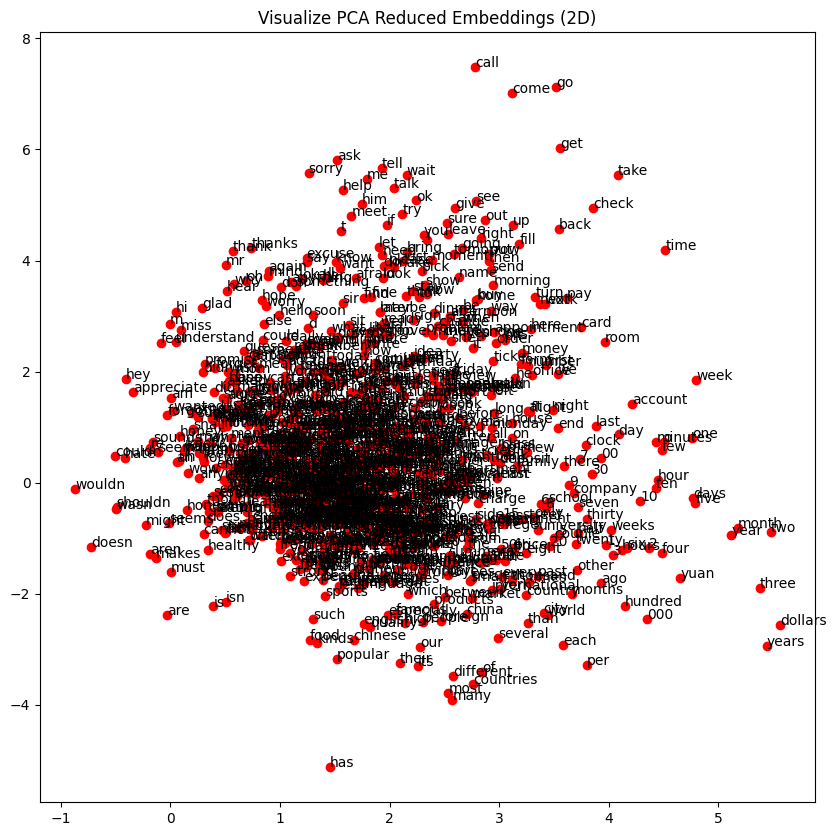

In [99]:
# Visualize Word Embeddings
# Extracting the word vectors from the model
word_vectors = extract_word_vectors(dailydialog_kv)
words = list(dailydialog_kv.wv.index_to_key)

# Applying PCA to reduce dimensions to 2
word_vecs_2d = pca_reduction(word_vectors, n_components=2)
    
fig = plt.figure(figsize=(10,10))  
plot_pca(fig, word_vecs_2d[:1000], words[:1000])
    
plt.title("Visualize PCA Reduced Embeddings (2D)")
plt.show()

Let's visualize PCA vs TSNE

Word count:  18683
Vector dimension:  100


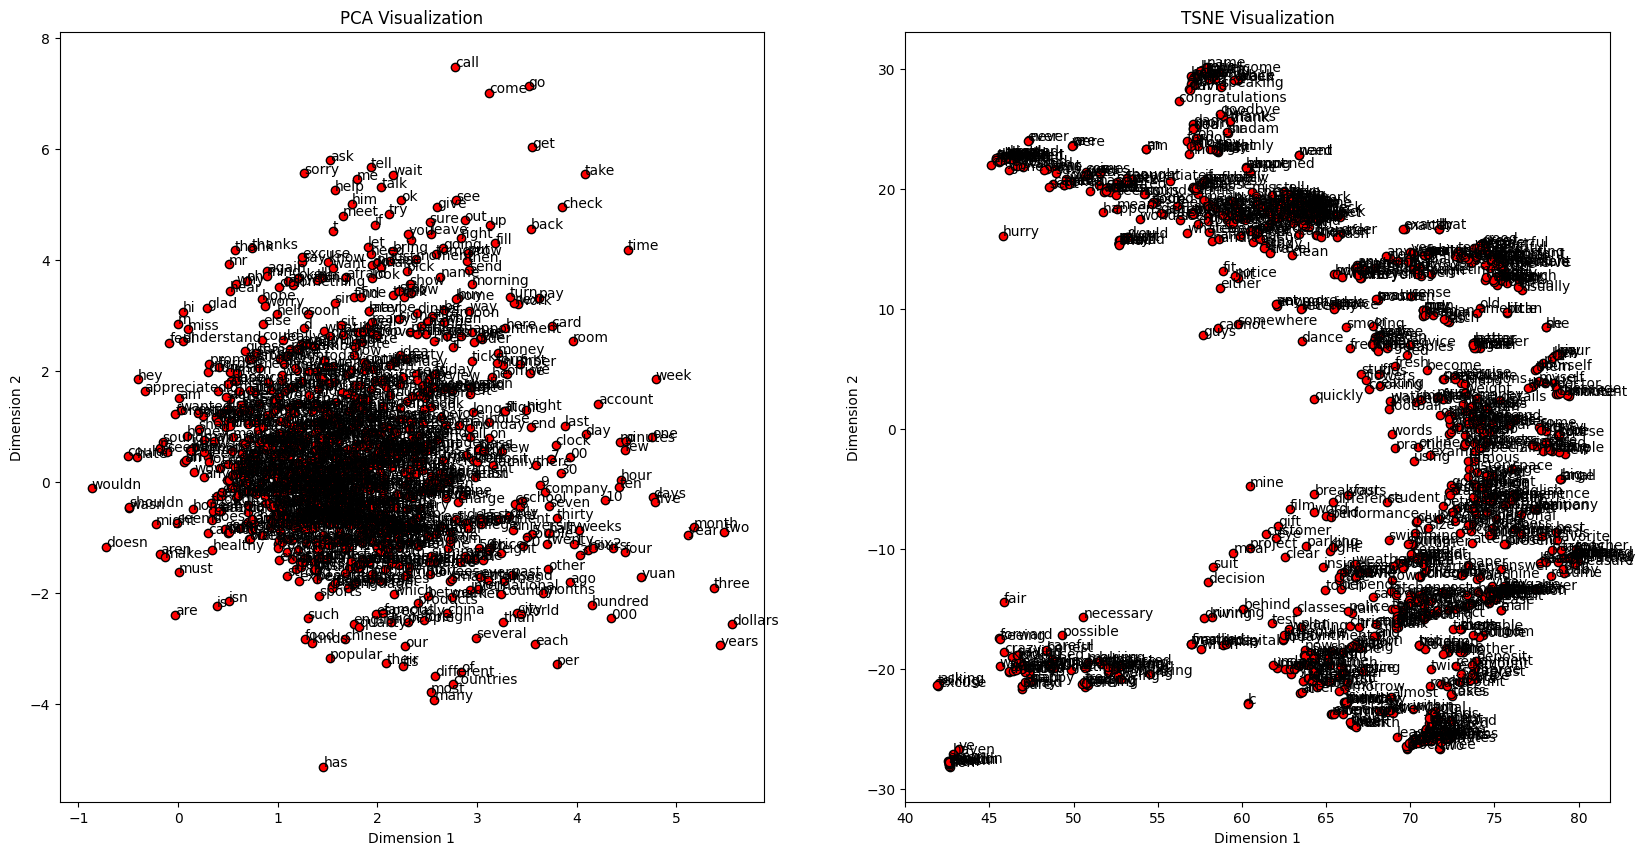

In [68]:
word_vectors = extract_word_vectors(dailydialog_kv)
word_vecs2d_pca = pca_reduction(word_vectors, n_components=2)
word_vecs2d_tsne = tsne_reduction(word_vectors, n_components=2)

# Plot side by sides
n = 1000
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(word_vecs2d_pca[:n, 0], word_vecs2d_pca[:n, 1], edgecolors='k', c='r')
for word, (x, y) in zip(words[:n], word_vecs2d_pca[:n]):
    plt.text(x, y, word)
    
plt.title("PCA Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.subplot(1, 2, 2)
plt.scatter(word_vecs2d_tsne[:n, 0], word_vecs2d_tsne[:n, 1], edgecolors='k', c='r')
for word, (x, y) in zip(words[:n], word_vecs2d_tsne[:n]):
    plt.text(x, y, word)
    
plt.title("TSNE Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.show()

Let's use 3D visualization

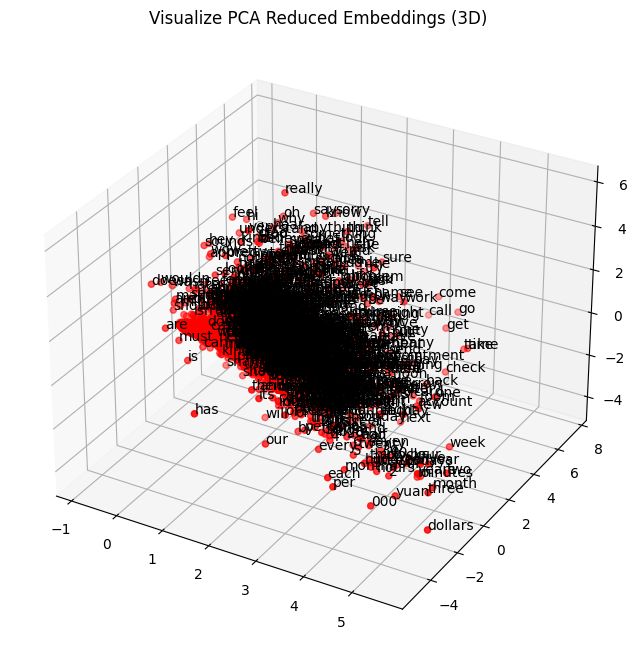

In [45]:
# Reduce dimensions to 3 using PCA
pca_3d = PCA(n_components=3)
word_vecs_3d_pca = pca_3d.fit_transform(word_vectors)

fig = plt.figure(figsize=(10, 8))
plot_pca(fig, word_vecs_3d_pca, words, three_dim=True)

plt.title("Visualize PCA Reduced Embeddings (3D)")
plt.show()

In [5]:
fig = go.Figure(data=[go.Scatter3d(
    x=word_vecs_3d_pca[:, 0],
    y=word_vecs_3d_pca[:, 1],
    z=word_vecs_3d_pca[:, 2],
    mode='markers+text',
    text=words,
    marker=dict(
        size=5,
        color='red',                # set color to an array/list of desired values
    ),
    textposition="top center"
)])

fig.update_layout(height=800, width=800, title='3D Word Embeddings Visualization')
fig.update_layout(scene=dict(
                    xaxis_title='X Axis',
                    yaxis_title='Y Axis',
                    zaxis_title='Z Axis'))
fig.show()

Let's also visualize similar words

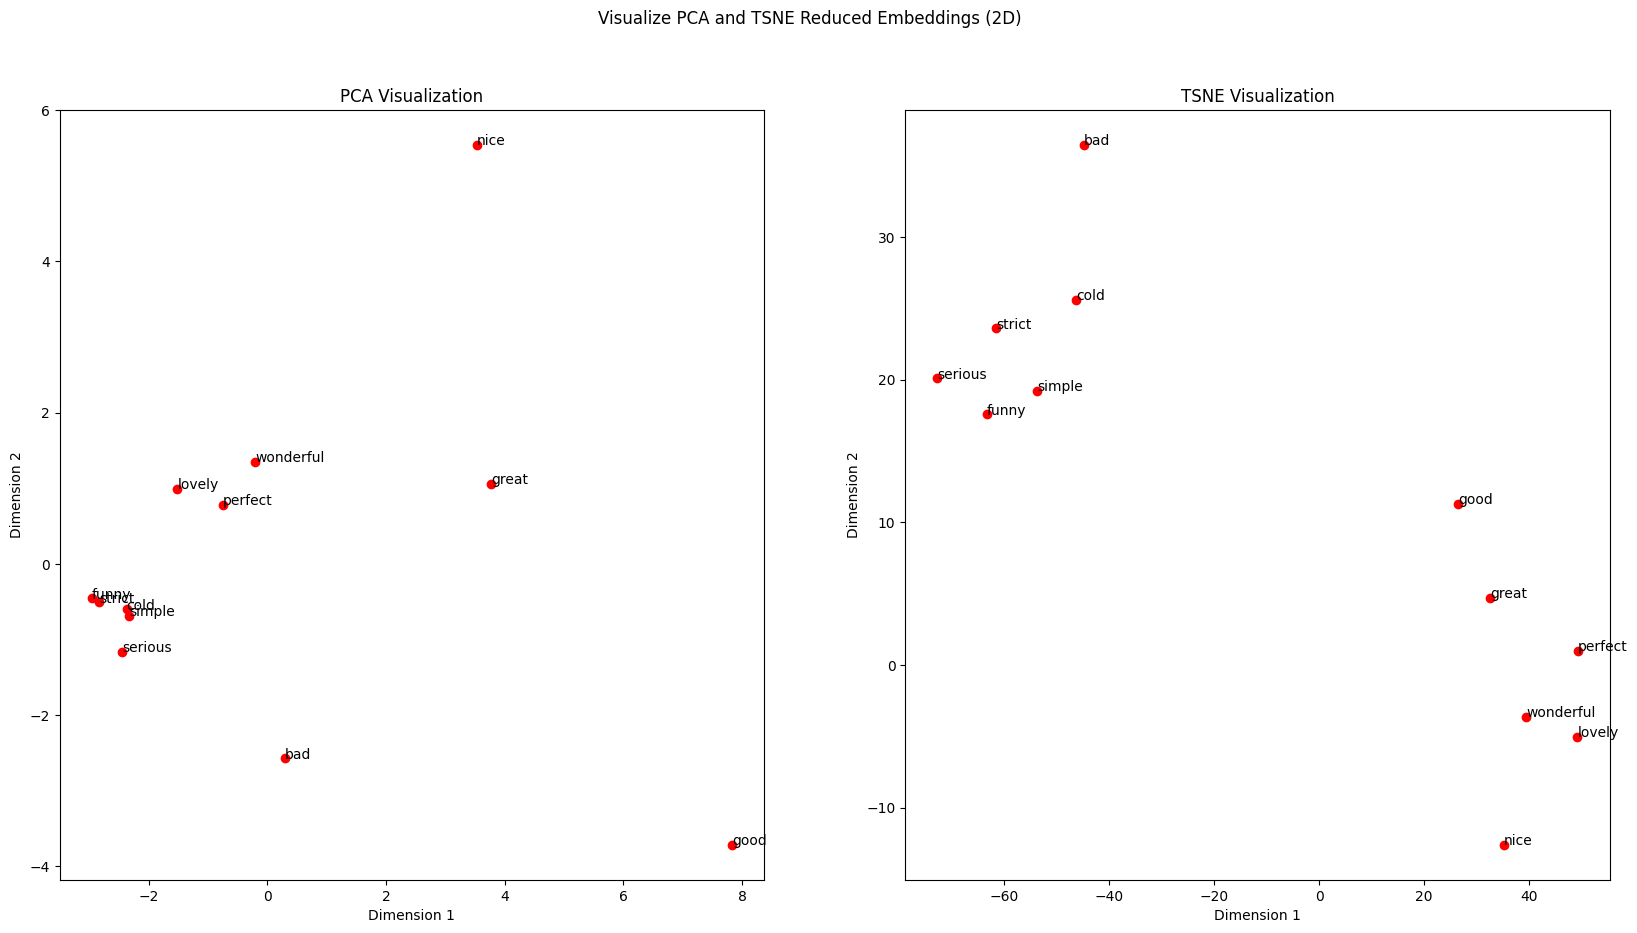

In [61]:
# Visualize "good" vs "bad" using pca and tsne
compare_words = ["great", "bad"]

fig = plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
all_words, reduction_total_word_vecs = similar_nonsimilar(compare_words, dailydialog_kv.wv, reduction='pca', k=5)
plot_pca(fig, reduction_total_word_vecs, all_words)
 
plt.title("PCA Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.subplot(1, 2, 2)
all_words, reduction_total_word_vecs = similar_nonsimilar(compare_words, dailydialog_kv.wv, reduction='tsne', k=5)
plot_pca(fig, reduction_total_word_vecs, all_words)

plt.title("TSNE Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Big title
plt.suptitle("Visualize PCA and TSNE Reduced Embeddings (2D)")
plt.show()


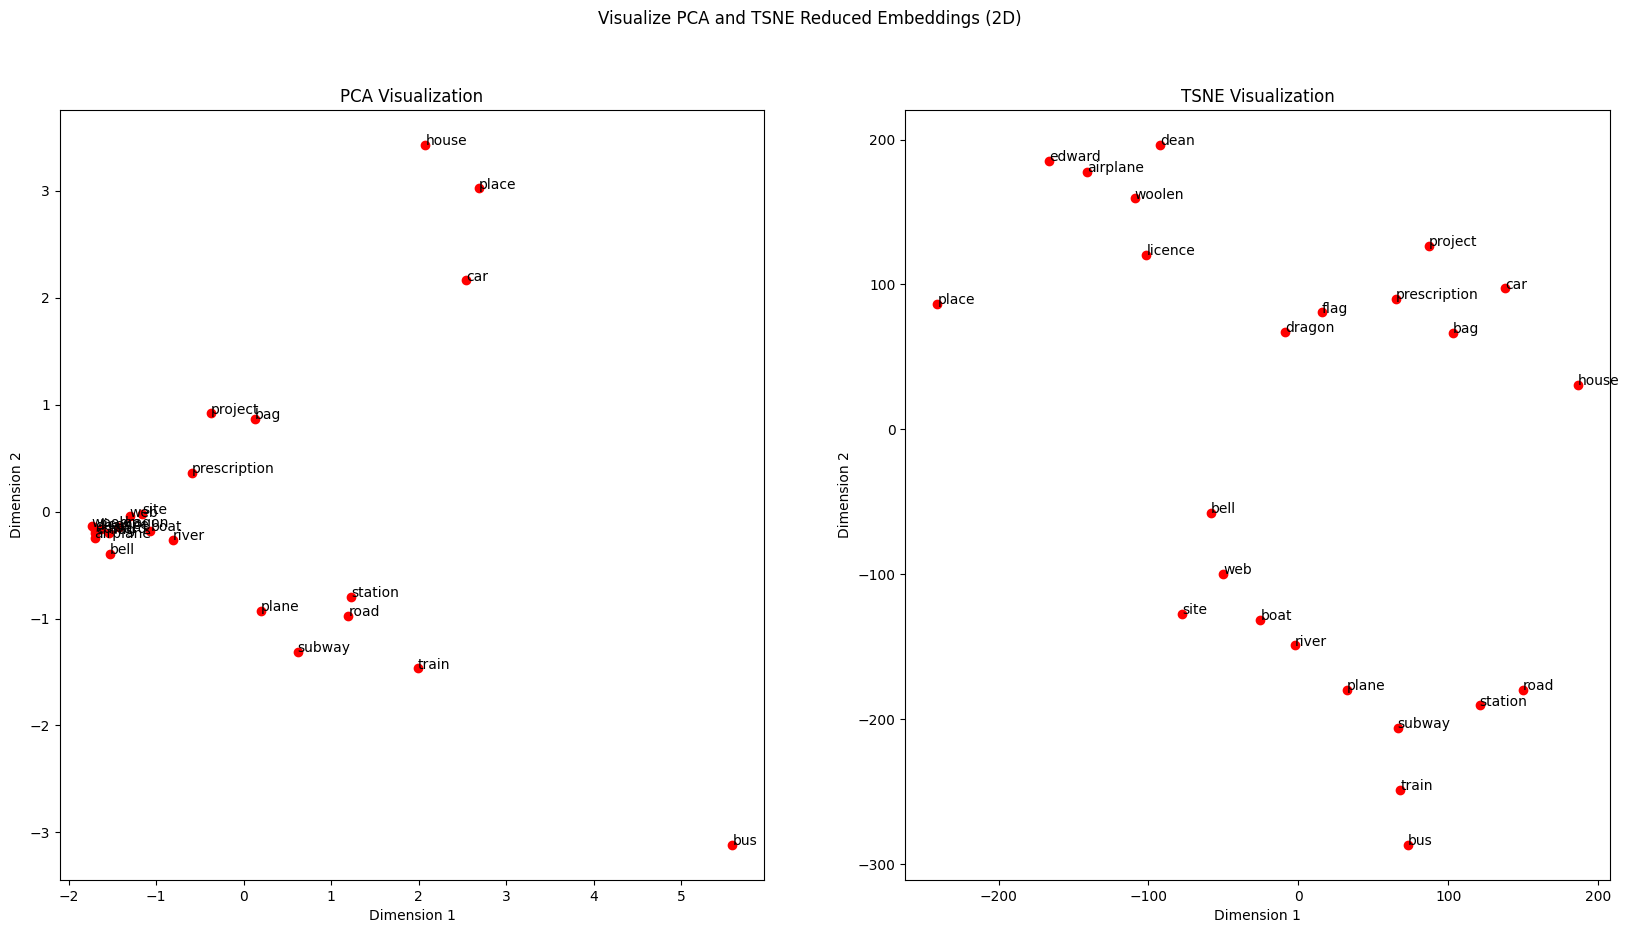

In [69]:
# Visualize "good" vs "bad" using pca and tsne
compare_words = ["airplane", "car", "boat", "train"]

fig = plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
all_words, reduction_total_word_vecs = similar_nonsimilar(compare_words, dailydialog_kv.wv, reduction='pca', k=5)
plot_pca(fig, reduction_total_word_vecs, all_words)
 
plt.title("PCA Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.subplot(1, 2, 2)
all_words, reduction_total_word_vecs = similar_nonsimilar(compare_words, dailydialog_kv.wv, reduction='tsne', k=5)
plot_pca(fig, reduction_total_word_vecs, all_words)

plt.title("TSNE Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Big title
plt.suptitle("Visualize PCA and TSNE Reduced Embeddings (2D)")
plt.show()

Let's try to capture relationships (analogies) and visualize them.

Analogy vev shape: (100,)
King vec shape (100,)


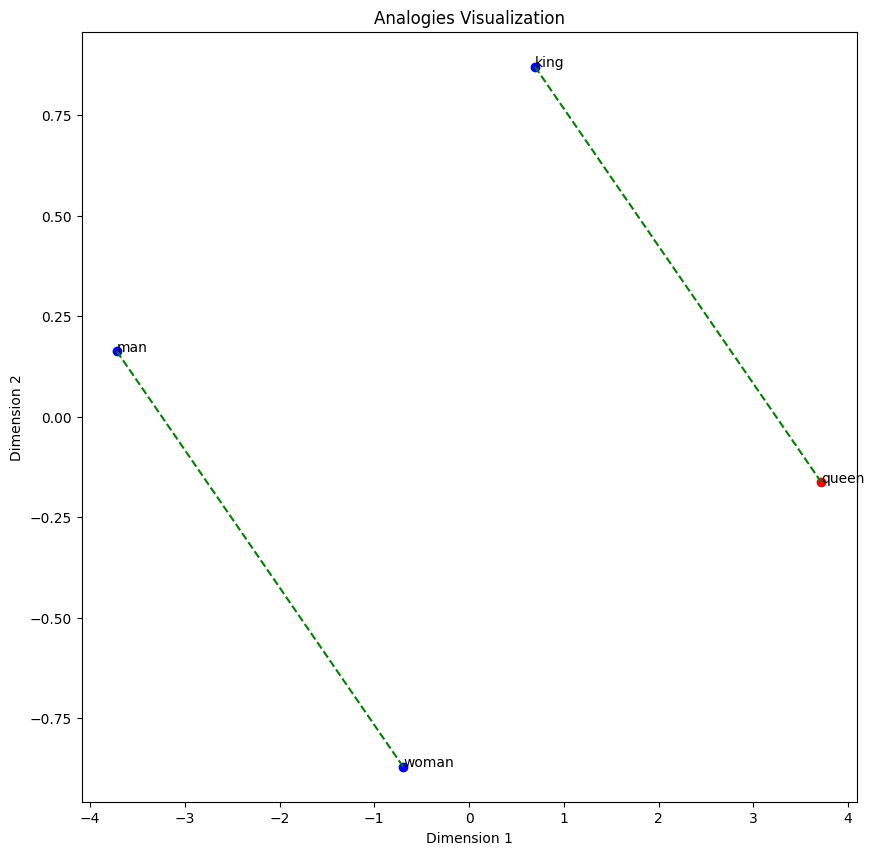

In [21]:
# Visualize analogies using word vectors
# i.e Showing king - man + woman = queen

# Define the analogy
analogy = ('king', 'man', 'woman')

# Get the vector representations of the words
king_vec = model.wv[analogy[0]]
man_vec = model.wv[analogy[1]]
woman_vec = model.wv[analogy[2]]

# Calculate the analogy vector
analogy_vec = king_vec - man_vec + woman_vec
king_vec, man_vec, woman_vec, analogy_vec = pca_reduction([king_vec, man_vec, woman_vec, analogy_vec], n_components=2)

# Plot the analogy vector
plt.figure(figsize=(10, 10))
plt.scatter(analogy_vec[0], analogy_vec[1], c='r', marker='o')
plt.text(analogy_vec[0], analogy_vec[1], 'queen')
plt.scatter([king_vec[0], man_vec[0], woman_vec[0]], [king_vec[1], man_vec[1], woman_vec[1]], c='b', marker='o')

plt.text(king_vec[0], king_vec[1], 'king')
plt.text(man_vec[0], man_vec[1], 'man')
plt.text(woman_vec[0], woman_vec[1], 'woman')

plt.plot([king_vec[0], analogy_vec[0]], [king_vec[1], analogy_vec[1]], 'g--')
plt.plot([man_vec[0], woman_vec[0]], [man_vec[1], woman_vec[1]], 'g--')


plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Analogies Visualization')
plt.show()


## Text8 Visualize
Let's visualize Text8 dataset.

In [95]:
text8_kv = Word2Vec.load("./out/text8_word2vec_100.model")
# text8_lsi_kv = LsiModel.load("./out/text8_LsiModel_100.model")
embedding_info(text8_kv)
# print(text8_lsi_kv)

Vector size: 100
Dictionary size 253854
Window size 5
Total training time 50.620567683596164
LsiModel<num_terms=253854, num_topics=7, decay=1.0, chunksize=20000>


In [6]:
# Extracting the word vectors from the model
word_vectors = extract_word_vectors(text8_kv)
words = list(text8_kv.wv.index_to_key)

# Applying PCA to reduce dimensions to 2
word_vecs_2d = pca_reduction(word_vectors, n_components=2)

# Just the first 1000
words = words[:1000]
word_vecs_2d = word_vecs_2d[:1000]

fig = plt.figure(figsize=(10,10))  
plot_pca(fig, word_vecs_2d, words)
    
plt.title("Visualize PCA Reduced Embeddings (2D) for text8")
plt.show()

NameError: name 'extract_word_vectors' is not defined

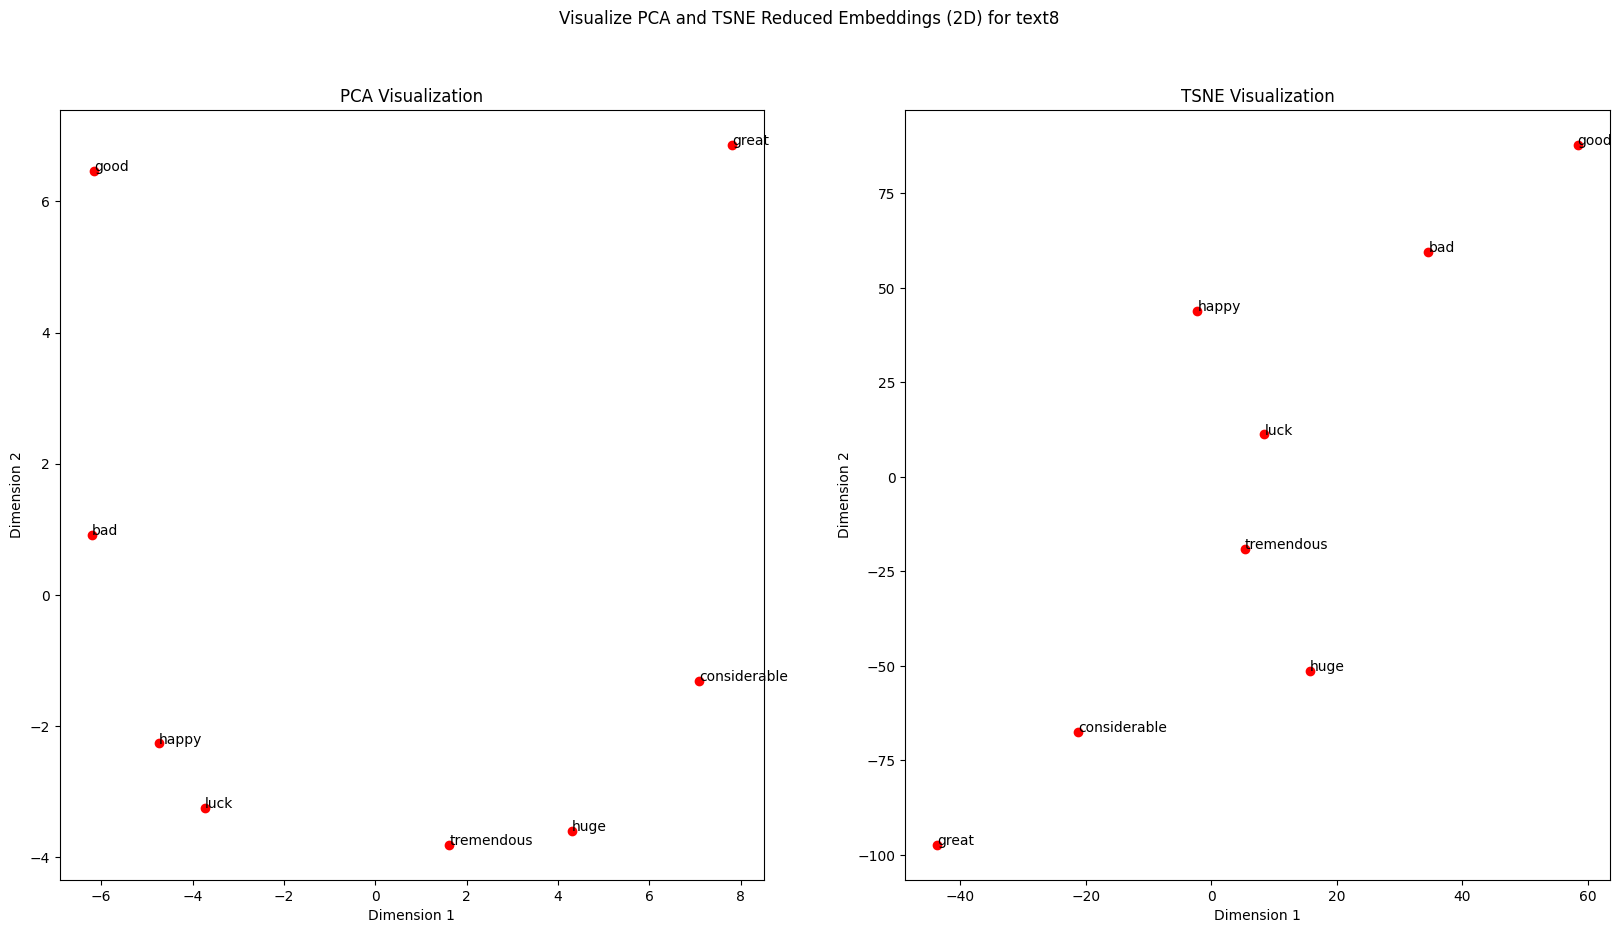

In [70]:
# Visualize "good" vs "bad" using pca and tsne
compare_words = ["great", "bad"]

fig = plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
all_words, reduction_total_word_vecs = similar_nonsimilar(compare_words, text8_kv.wv, reduction='pca', k=3)
plot_pca(fig, reduction_total_word_vecs, all_words)
 
plt.title("PCA Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.subplot(1, 2, 2)
all_words, reduction_total_word_vecs = similar_nonsimilar(compare_words, text8_kv.wv, reduction='tsne', k=3)
plot_pca(fig, reduction_total_word_vecs, all_words)

plt.title("TSNE Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Big title
plt.suptitle("Visualize PCA and TSNE Reduced Embeddings (2D) for text8")
plt.show()

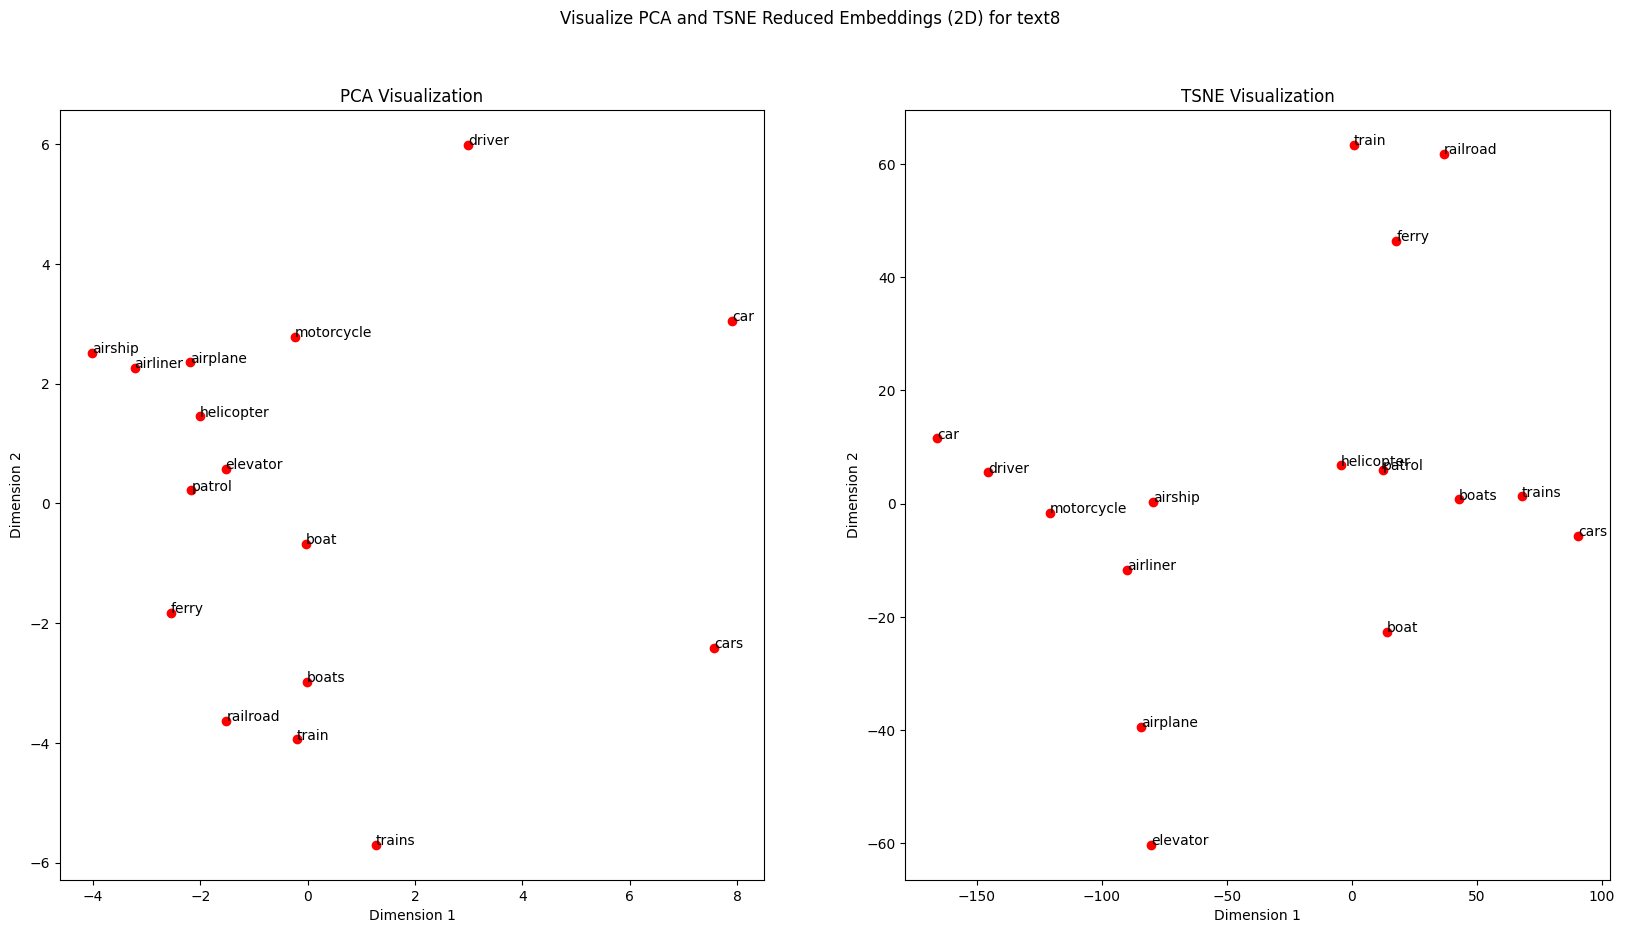

In [71]:
compare_words = ["airplane", "car", "boat", "train"]
fig = plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
all_words, reduction_total_word_vecs = similar_nonsimilar(compare_words, text8_kv.wv, reduction='pca', k=3)
plot_pca(fig, reduction_total_word_vecs, all_words)
 
plt.title("PCA Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.subplot(1, 2, 2)
all_words, reduction_total_word_vecs = similar_nonsimilar(compare_words, text8_kv.wv, reduction='tsne', k=3)
plot_pca(fig, reduction_total_word_vecs, all_words)

plt.title("TSNE Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Big title
plt.suptitle("Visualize PCA and TSNE Reduced Embeddings (2D) for text8")
plt.show()

## Google News Embeddings

Let's visualize contrasting terms.

In [78]:
google_news_kv : KeyedVectors = models.KeyedVectors.load_word2vec_format(
    './data/GoogleNews-vectors-negative300.bin', binary=True)

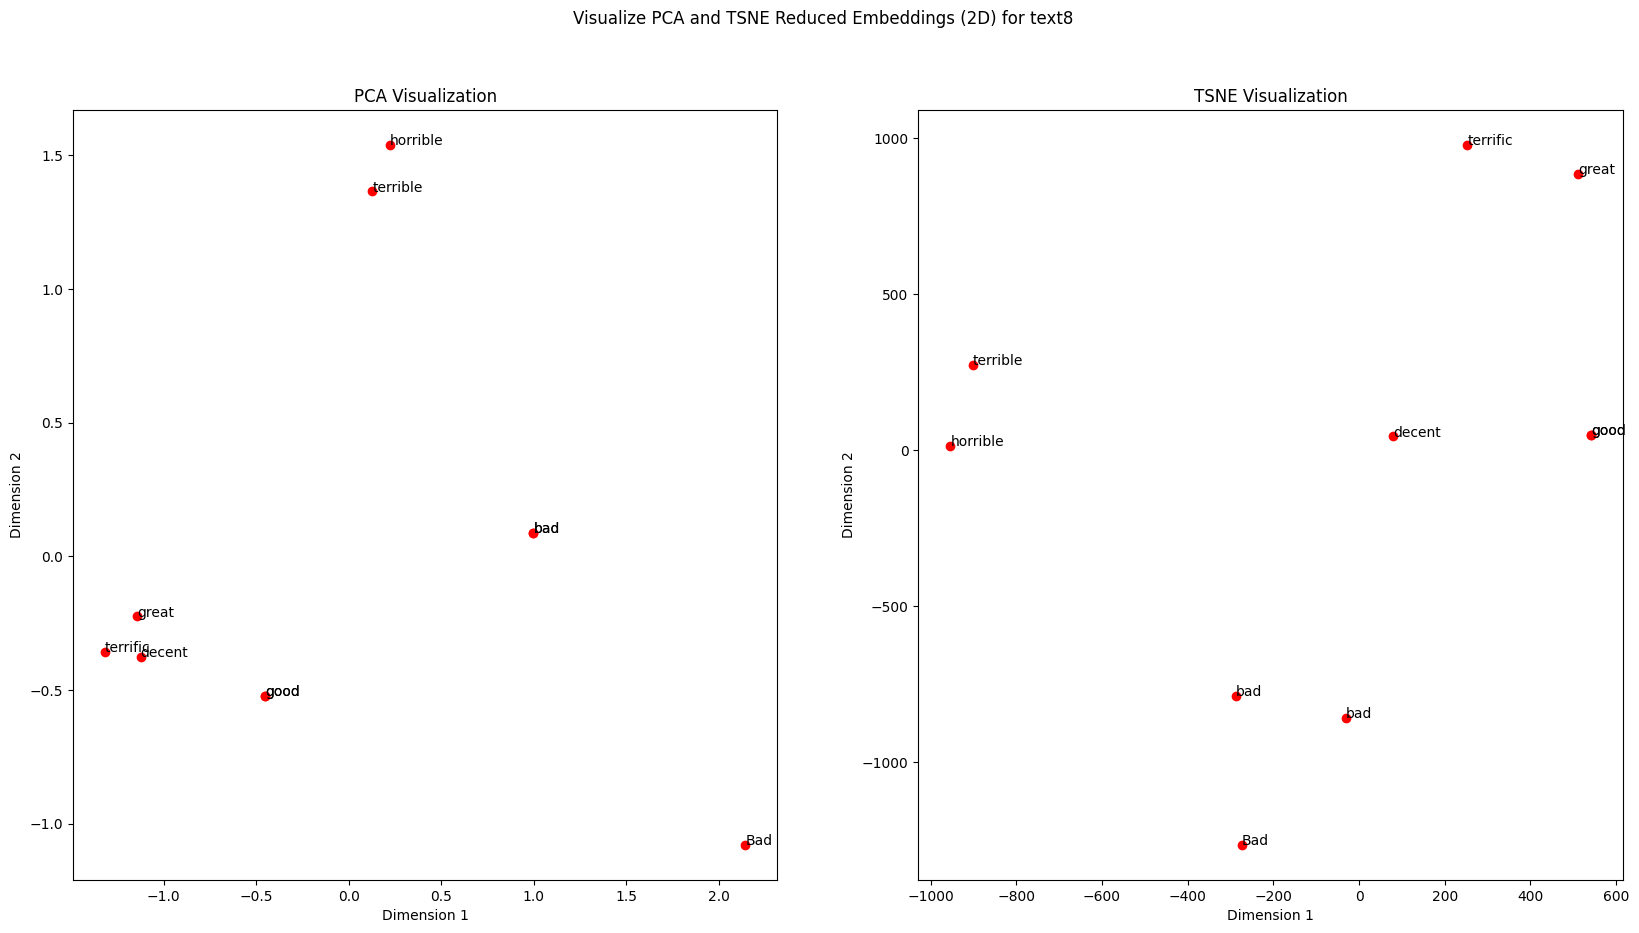

In [77]:
compare_words = ["good", "bad"]
fig = plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
all_words, reduction_total_word_vecs = similar_nonsimilar(compare_words, google_news_kv, reduction='pca', k=4)
plot_pca(fig, reduction_total_word_vecs, all_words)
 
plt.title("PCA Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.subplot(1, 2, 2)
all_words, reduction_total_word_vecs = similar_nonsimilar(compare_words, google_news_kv, reduction='tsne', k=4)
plot_pca(fig, reduction_total_word_vecs, all_words)

plt.title("TSNE Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.suptitle("Visualize PCA and TSNE Reduced Embeddings (2D) for text8")
plt.show()

We see that there is a good seperation between "good" related terms and "bad" related terms.

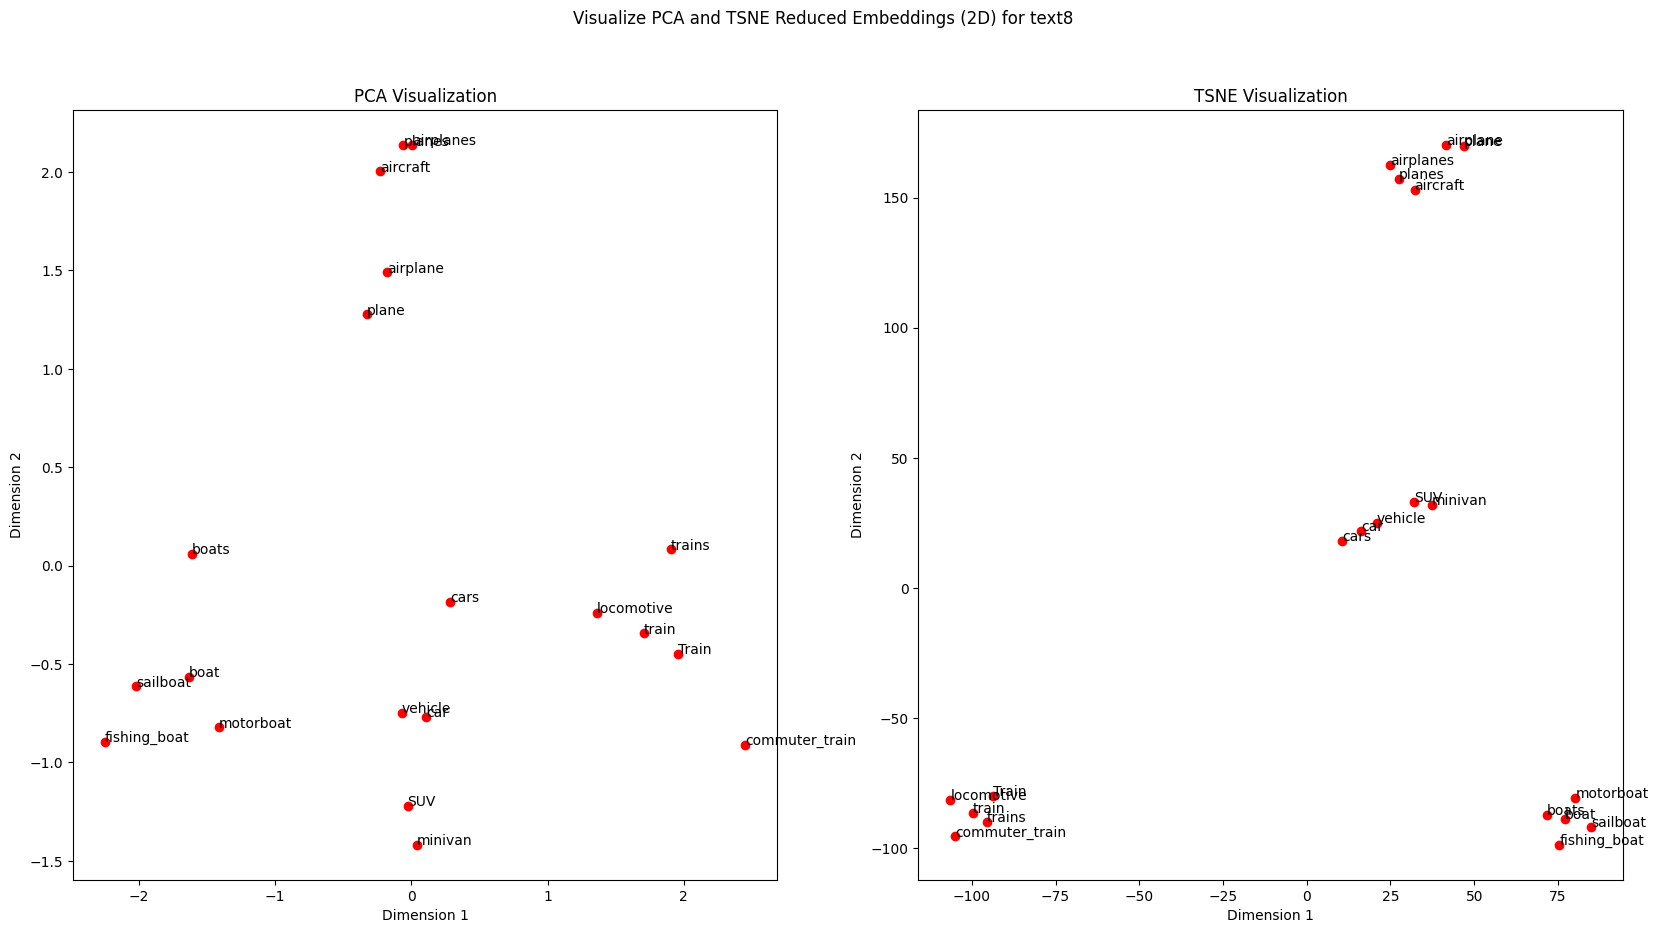

In [75]:
compare_words = ["airplane", "car", "boat", "train"]
fig = plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
all_words, reduction_total_word_vecs = similar_nonsimilar(compare_words, google_news_kv, reduction='pca', k=4)
plot_pca(fig, reduction_total_word_vecs, all_words)
 
plt.title("PCA Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.subplot(1, 2, 2)
all_words, reduction_total_word_vecs = similar_nonsimilar(compare_words, google_news_kv, reduction='tsne', k=4)
plot_pca(fig, reduction_total_word_vecs, all_words)

plt.title("TSNE Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.suptitle("Visualize PCA and TSNE Reduced Embeddings (2D) for text8")
plt.show()

Here we see a much clearer groups between each group

## Glove Twitter 27B 100d

In [3]:
glove_twitter_kv = load_word_vectors('./data/glove_twitter_27B/glove.twitter.27B.100d.txt')

# Print size in memory

In [21]:
print(len(glove_twitter_kv))

# Visualize embeddings
glove_words = list(glove_twitter_kv.keys())
glove_vectors = np.array([])
for word in tqdm(glove_words):
    if word in glove_twitter_kv:
        glove_vectors = np.append(glove_vectors, glove_twitter_kv[word])

# glove_vectors = np.array([glove_twitter_kv[word] for word in glove_words])

# PCA and TSNE reduction
glove_vectors_2d = pca_reduction(glove_vectors, n_components=2)

# Plot the PCA reduced embeddings
fig = plt.figure(figsize=(10, 10))
plot_pca(fig, glove_vectors_2d[:1000], glove_words[:1000])

plt.title("Visualize PCA Reduced Embeddings (2D) for Glove Twitter")

1193514


NameError: name 'tqdm' is not defined

[('airplane', 0.99999994), ('plane', 0.77781284), ('helicopter', 0.68330306), ('passenger', 0.65992767), ('boat', 0.6428787)]
[('car', 1.0), ('truck', 0.826445), ('front', 0.7653979), ('cars', 0.7632982), ('driving', 0.7351885)]
[('boat', 1.0), ('plane', 0.7483092), ('cruise', 0.7481595), ('boats', 0.74050635), ('fishing', 0.73672235)]
[('train', 0.9999999), ('trains', 0.71176696), ('back', 0.6932096), ('bus', 0.687421), ('route', 0.6615707)]


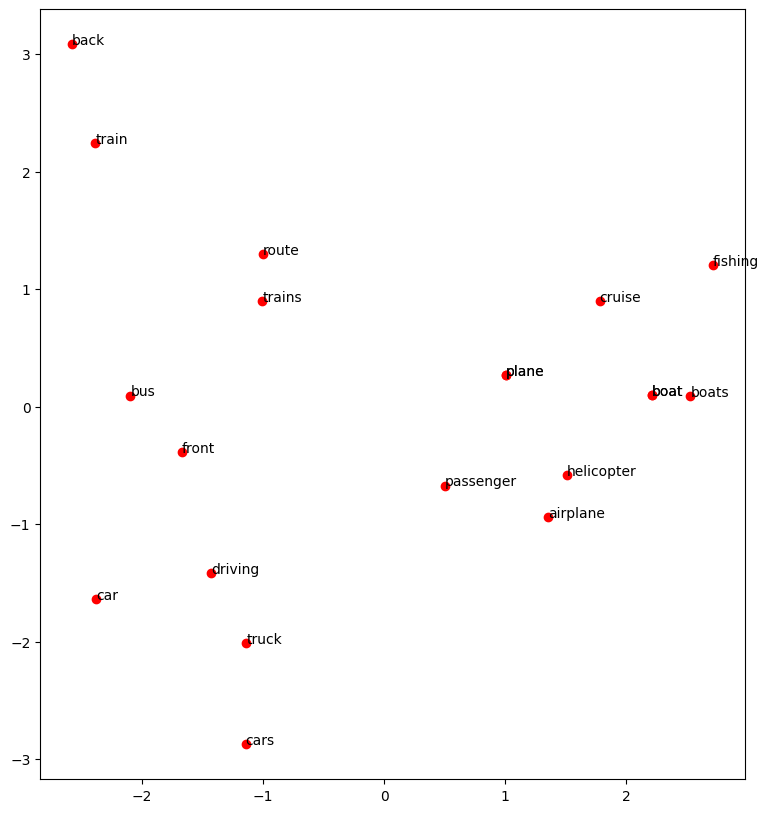

In [10]:
compare_words = ["airplane", "car", "boat", "train"]

# Get top 5 similar words for each word
all_words = []
all_vecs = np.empty((0, 100))
for word in compare_words:
    sim_words = most_similar_words(glove_twitter_kv, word, k=5)
    sim_words_vec = np.array([glove_twitter_kv[word] for word, _ in sim_words])
    
    print(sim_words)
    
    all_words.extend([word for word, _ in sim_words])
    all_vecs = np.concatenate((all_vecs, sim_words_vec), axis=0)
    
# PCA reduction
all_vecs_2d = pca_reduction(all_vecs, n_components=2)

# Graph
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plot_pca(fig, all_vecs_2d, all_words)

plt.show()

[('great', 0.9999999), ('good', 0.89955086), ('amazing', 0.89360267), ('awesome', 0.8772659), ('wonderful', 0.8646038)]
[('bad', 1.0), ('but', 0.8499987), ('shit', 0.8407029), ('really', 0.83760744), ('way', 0.83037084)]


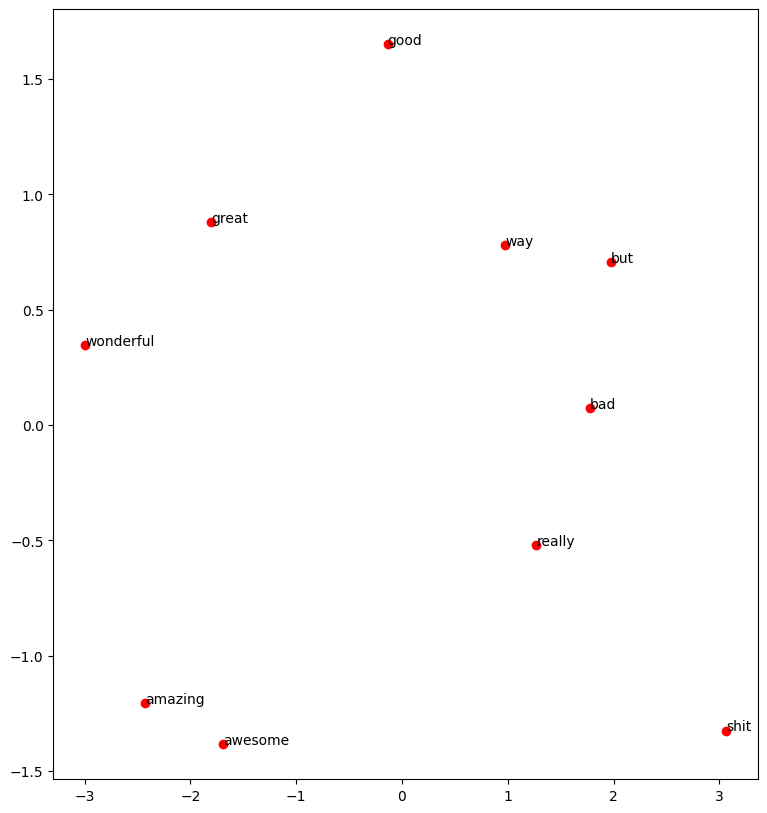

In [11]:
compare_words = ["great", "bad"]

# Get top 5 similar words for each word
all_words = []
all_vecs = np.empty((0, 100))
for word in compare_words:
    sim_words = most_similar_words(glove_twitter_kv, word, k=5)
    sim_words_vec = np.array([glove_twitter_kv[word] for word, _ in sim_words])
    
    print(sim_words)
    
    all_words.extend([word for word, _ in sim_words])
    all_vecs = np.concatenate((all_vecs, sim_words_vec), axis=0)
    
# PCA reduction
all_vecs_2d = pca_reduction(all_vecs, n_components=2)

# Graph
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plot_pca(fig, all_vecs_2d, all_words)

plt.show()

## 20 News Group


In [4]:
newsgroup_lda = LdaModel.load("./out/20newsgroup_LdaModel_20.model")
print(newsgroup_lda)
topics = newsgroup_lda.print_topics(newsgroup_lda.num_topics)
for topic in topics:
    print(topic)
    

# Compute Perplexity
loader = Loader()
newsgroup_corpus = loader.load_json("./out/20newsgroup_corpus.json")
dictionary = corpora.Dictionary(newsgroup_corpus)
corpus = [dictionary.doc2bow(text) for text in newsgroup_corpus]
print(len(corpus))
print("Log Perplexity Score", newsgroup_lda.log_perplexity(corpus))

LdaModel<num_terms=61081, num_topics=20, decay=0.5, chunksize=100>
(0, '0.629*"ax" + 0.075*"q" + 0.028*"l" + 0.018*"b" + 0.015*"self" + 0.013*"family" + 0.010*"r" + 0.010*"p" + 0.009*"g" + 0.007*"link"')
(1, '0.033*"program" + 0.031*"file" + 0.029*"window" + 0.019*"run" + 0.018*"set" + 0.017*"problem" + 0.017*"do" + 0.016*"image" + 0.015*"send" + 0.015*"physical"')
(2, '0.012*"case" + 0.012*"make" + 0.012*"state" + 0.010*"many" + 0.009*"right" + 0.008*"year" + 0.008*"people" + 0.008*"government" + 0.008*"also" + 0.008*"group"')
(3, '0.056*"science" + 0.055*"patient" + 0.054*"die" + 0.035*"drug" + 0.035*"study" + 0.029*"disease" + 0.027*"scientific" + 0.024*"treatment" + 0.021*"health" + 0.019*"national"')
(4, '0.251*"_" + 0.057*"israeli" + 0.034*"arab" + 0.024*"bomb" + 0.024*"son" + 0.024*"militia" + 0.020*"creation" + 0.017*"daughter" + 0.016*"remote" + 0.014*"imho"')
(5, '0.035*"kill" + 0.021*"attack" + 0.020*"death" + 0.020*"war" + 0.020*"soldier" + 0.018*"armenian" + 0.017*"murder"

In [5]:
# Compute Coherence Score
coherence_score = CoherenceModel(model=newsgroup_lda, texts=newsgroup_corpus, dictionary=dictionary, coherence='c_v')
print("Coherence Score", coherence_score.get_coherence())

/home/ltq/developer/miniconda3/envs/py38/lib/python3.8/site-packages/gensim/topic_coherence/text_analysis.py:442: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn("stats accumulation interrupted; <= %d documents processed", self._num_docs)


KeyboardInterrupt: 

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(newsgroup_lda, corpus, dictionary)
vis

/home/ltq/developer/miniconda3/envs/py38/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.310141  0.106654       1        1  20.639805
2      0.309559  0.115492       2        1  18.411018
15     0.278454 -0.078933       3        1  14.056750
18     0.283432  0.163809       4        1   9.920171
17     0.201449 -0.106047       5        1   8.974992
1      0.167933 -0.122254       6        1   6.519628
0     -0.016661 -0.252883       7        1   6.514352
5      0.038411  0.148404       8        1   2.796756
6      0.003289 -0.249032       9        1   2.722903
19     0.016457  0.006889      10        1   2.442177
12    -0.024367 -0.024438      11        1   2.330688
9     -0.076846 -0.030770      12        1   1.329241
3     -0.114377  0.013859      13        1   1.147143
16    -0.155684  0.030276      14        1   0.745395
4     -0.166464  0.037845      15        1   0.613641
7     -0.199876  0.048145      16        1   0.319831
14    -0.198088  0.044000      17        1   0.281346
10    -0.213643  0.049639      18        1   0.144073
8     -0.221897  0.049674      19        1   0.047339
13    -0.221222  0.049672      20        1   0.042751, topic_info=               Term          Freq         Total Category  logprob  loglift
4829             ax  54943.000000  54943.000000  Default  30.0000   30.000
17             line  18058.000000  18058.000000  Default  29.0000   29.000
1932              r   7661.000000   7661.000000  Default  28.0000   28.000
209           write  13722.000000  13722.000000  Default  27.0000   27.000
24     organization  10849.000000  10849.000000  Default  26.0000   26.000
...             ...           ...           ...      ...      ...      ...
8936         sector      0.008403      1.191612  Topic20 -11.1305    2.803
5907        install      0.008403      1.191629  Topic20 -11.1305    2.803
11140        conner      0.008403      1.191603  Topic20 -11.1305    2.803
4238           byte      0.008403      1.191628  Topic20 -11.1305    2.803
6556       exercise      0.008403      1.191597  Topic20 -11.1305    2.803

[896 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1776     17  0.879983      1983_h
2184     10  0.211648         1st
2184     11  0.784557         1st
3230     17  0.549238        60ns
1628     15  0.999244           _
...     ...       ...         ...
638       3  0.998839  x_newsread
40        1  0.314998        year
40        2  0.459400        year
40        8  0.010126        year
40       10  0.215502        year

[1043 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 3, 16, 19, 18, 2, 1, 6, 7, 20, 13, 10, 4, 17, 5, 8, 15, 11, 9, 14])